<a href="https://colab.research.google.com/github/bioangel/GeminiProChat/blob/main/02_multi_modal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Environment

Let's install the necessary Python packages.

In [29]:
!pip install langchain langchain-openai unstructured[all-docs] pydantic lxml openai chromadb tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00


In [3]:
!wget -O weekly_market_recap.pdf https://am.jpmorgan.com/content/dam/jpm-am-aem/americas/us/en/insights/market-insights/wmr/weekly_market_recap.pdf

--2024-11-20 12:17:52--  https://am.jpmorgan.com/content/dam/jpm-am-aem/americas/us/en/insights/market-insights/wmr/weekly_market_recap.pdf
Resolving am.jpmorgan.com (am.jpmorgan.com)... 159.53.117.93
Connecting to am.jpmorgan.com (am.jpmorgan.com)|159.53.117.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209630 (205K) [application/pdf]
Saving to: ‘weekly_market_recap.pdf’

weekly_market_recap 100%[===================>] 204.72K   585KB/s    in 0.4s    

2024-11-20 12:17:52 (585 KB/s) - ‘weekly_market_recap.pdf’ saved [209630/209630]



In [4]:
!apt-get install poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  poppler-utils tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,002 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 5,002 kB in 2s (2,734 kB/s)
Selecting previously unselected package popp

In [36]:
import os

os.environ["OPENAI_API_KEY"] = "sk-oxESzKH1s8PzTM_C6huXQA"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://aiverse-row.ludp.lenovo.com/ics-apps/projects/115/heartmovie/aiverse/endpoint/v1/"

### Coding

#### Use `unstructured` library to partition the PDF document into different type of elements.

In [16]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [22]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

images_path = "./figures/"
raw_pdf_elements = partition_pdf(
    filename="weekly_market_recap.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=images_path,
)

In [12]:
!ls -alt figures/

total 116
-rw-r--r-- 1 root root 108783 Nov 20 12:22 figure-1-1.jpg
drwxr-xr-x 2 root root   4096 Nov 20 12:20 .
drwxr-xr-x 1 root root   4096 Nov 20 12:20 ..


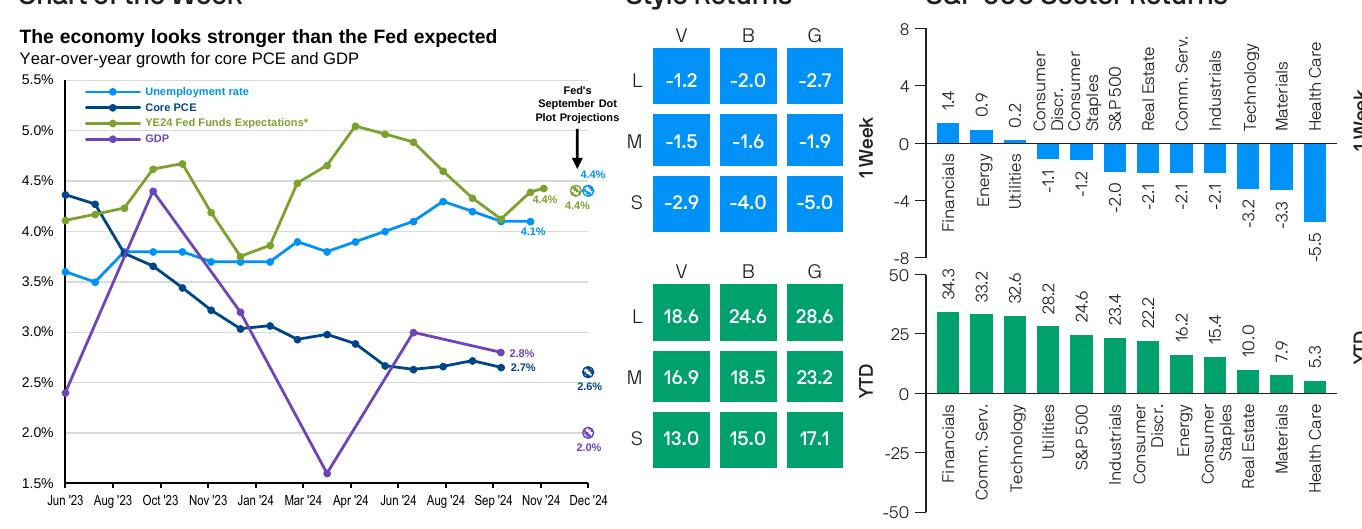

In [13]:
from IPython.display import Image
Image('figures/figure-1-1.jpg')

#### Summarize the extracted images

In [37]:
# Image summarizer

import base64
import os

from langchain_openai.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage

class ImageSummarizer:

    def __init__(self, image_path) -> None:
        self.image_path = image_path
        self.prompt = """
You are an assistant tasked with summarizing images for retrieval.
These summaries will be embedded and used to retrieve the raw image.
Give a concise summary of the image that is well optimized for retrieval.
"""

    def base64_encode_image(self):
        with open(self.image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

    def summarize(self, prompt = None):
        base64_image_data = self.base64_encode_image()
        chat = ChatOpenAI(base_url=os.environ["AZURE_OPENAI_ENDPOINT"], model="gpt-4o", max_tokens=1000)

        # gpt4o api doc - https://platform.openai.com/docs/guides/vision
        response = chat.invoke(
            [
                HumanMessage(
                    content=[
                        {
                            "type": "text",
                            "text": prompt if prompt else self.prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{base64_image_data}"},
                        },
                    ]
                )
            ]
        )
        return base64_image_data, response.content

In [41]:
image_data_list = []
image_summary_list = []

for img_file in sorted(os.listdir(images_path)):
    if img_file.endswith(".jpg"):
        summarizer = ImageSummarizer(os.path.join(images_path, img_file))
        data, summary = summarizer.summarize()
        image_data_list.append(data)
        image_summary_list.append(summary)

APIConnectionError: Connection error.

In [21]:
image_summary_list

[]

#### Categorize the elements into tables and texts

In [ ]:
class Element(BaseModel):
    type: str
    text: Any

table_elements = []
text_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        table_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        text_elements.append(Element(type="text", text=str(element)))

In [ ]:
print(len(table_elements))
print(len(text_elements))

1
6


In [ ]:
table_elements[0]

Element(type='table', text='MSCI EM 977 2.99 2.62 4.84 6.86 -11.35 1.68 1.55 3.18 6687 NASDAQ 14125 242 6.98 35.98 27.83 21.52 26.20 5.42 0.77 22940 Levels Fixed Income Yield 1 week QTD YTD 1year 3-yr.Cum. Currencies 11/17/23 12/30/22 11/17/22 U.S. Aggregate 5.21 1.37 41.77 0.54. 1.19 -13.40 $per€ 1.09 1.07 1.03 U.S. Corporates 5.83 1.75 2.32 2.33 3.41 13.37. $perf 1.24 1.20 1.18 Municipals (10yr) 3.54 1.25 2.92 1.30 3.25 -3.37 ¥per$ 149.58 131.95 140.58 High Yield 8.82 0.88 1.85 7.81 8.40 3.61 Levels (%) Levels Key Rates 11/17/23 11/10/23 9/29/23 12/30/22 11/17/22 11/17/20 Commod. 11/17/23 12/30/22 11/17/22 2-yr U.S. Treasuries 4.88 5.04 5.03 441 4.43 0.18 — Oil (WTI) 72.92 80.16 81.69 10-yr U.S. Treasuries 4.44 4.61 4.59 3.88 3.77 0.87. Gasoline 3.35 3.09 3.76 30-yr U.S. Treasuries 4.59 4.73 4.73 3.97 3.89 1.62 Natural Gas 3.07 3.52 6.20 10-yr German Bund 2.58 2.72 2.82 2.53 2.02 -0.56 Gold 1981 1814 1159 3-mo. LIBOR 5.63 5.64 5.66 477 4.68 0.23 Silver 24.00 23.95, 21.08 3-mo. EURIBO

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

#### Build up summarization chain with LangChain framework

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

prompt_text = """
  You are responsible for concisely summarizing table or text chunk:

  {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)
summarize_chain = {"element": lambda x: x} | prompt | ChatOpenAI(temperature=0, model="gpt-3.5-turbo") | StrOutputParser()

#### Summarize each text and table element

In [ ]:
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

#### Use LangChain MultiVectorRetriever to associate summaries of tables, texts and images with original data chunks in parent-child relationship.

In [ ]:
import uuid

from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings()),
    docstore=InMemoryStore(),
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add images
# image_data_list = []
# image_summary_list = []
doc_ids = [str(uuid.uuid4()) for _ in image_data_list]
summary_images = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(image_summary_list)
]
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(doc_ids, image_data_list)))

#### Image helper functions

In [ ]:
from PIL import Image
from IPython.display import HTML, display
import io
import re


def plt_img_base64(img_base64):
    display(HTML(f'<img src="data:image/jpeg;base64,{img_base64}" />'))

def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content

        if is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding texts to the messages
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to answer the user question in the finance. \n"
            f"Question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

In [ ]:
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough

model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | model
    | StrOutputParser()
)

In [ ]:
query = "Which year had the highest holiday sales growth?"

In [ ]:
chain.invoke(query)

'The year with the highest holiday sales growth, as shown in the provided image, is 2021 with a growth rate of 12.7%. This is indicated by the tallest bar in the chart, which represents actual sales growth for November and December of that year.'

In [ ]:
docs = retriever.get_relevant_documents(query)

len(docs)

4

In [ ]:
docs

["Chart of the Week\n\nStyle Returns\n\nS&P 500 Sector Returns\n\nHoliday sales growth is set to return to its pre-pandemic pace G e713 Noy November & December sales, % y/y growth, nsa 65 3 3 2 14% Actual 12% a SS Forecast 10% 2020-22 average 9.1% 8% 2010-19 average 6% 5.2% 46% 4.8% 5.0% 4% 3.8% Fox 2.7% [2.00 2% 1.7% 0% ‘10 ‘11 ‘12 ‘13 ‘14 ‘15 ‘16 ‘17 ‘18 ‘19 ‘20 ‘21 ‘22 '23 5.4% B » a = iti 1Week 23 23 © 0 © 2@ey 8 @H8 sO Fe BE ao 2S5m5 25 FS BR BQ # fesse 8 § 8 §Eo 2 9 30 Be@2ae0 c 39 w Bats OB cs Or 3845 82 cs 5 5 € RB £ EH BH €2s £ Be ES 6 e« 9° = 8 er ° Oo g , © 5 8 £ Ea? & B3e8e ao @ FESR S$ £52 YO ¢ GOST > sheo oo oN F25sS gana Ssesse ego @ 2300 % & 2 £e2 438 8 S ES vos ge §o £ ic 8 1Week\n\nNot FDIC Insured | No Bank Guarantee | May Lose Value\n\nMarket Insights",
 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wA

In [ ]:
is_image_data(docs[1])

True


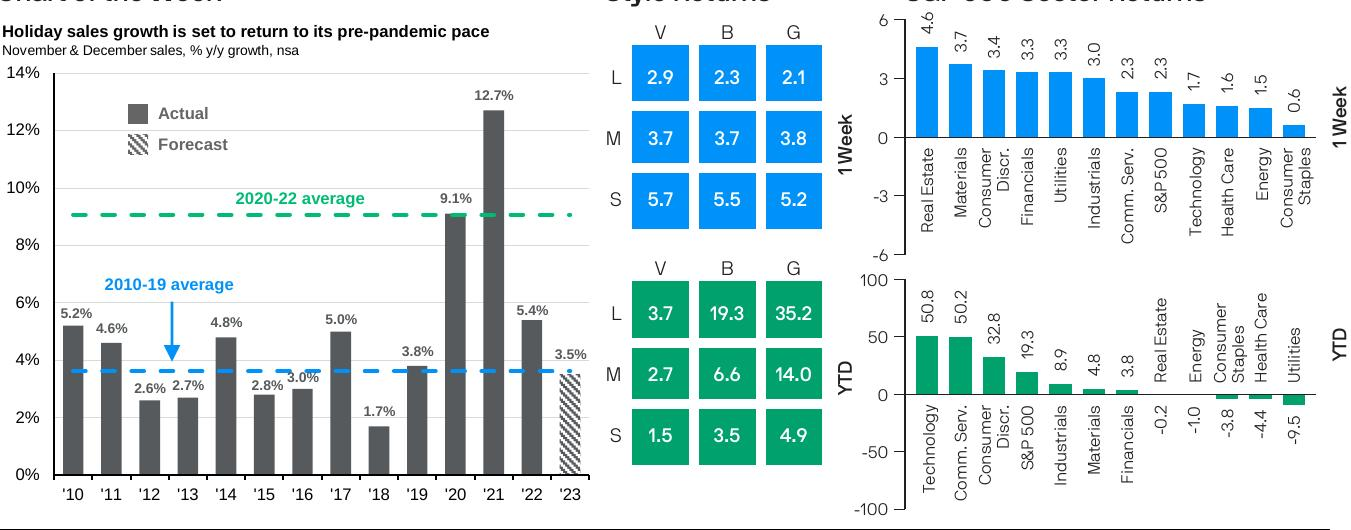

In [ ]:
plt_img_base64(docs[1])